In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load the dataset
df = pd.read_csv("/content/auto-mpg.csv")

# Convert 'horsepower' to numeric, handling '?' values
df["horsepower"] = pd.to_numeric(df["horsepower"], errors="coerce")
df["horsepower"] = df["horsepower"].fillna(df["horsepower"].median())

# Drop non-numeric column
df.drop(columns=["car name"], inplace=True)

# Feature Selection using Variance Threshold
X = df.drop(columns=["mpg"])
y = df["mpg"]
selector = VarianceThreshold(threshold=0.1)
X_selected = selector.fit_transform(X)
selected_feature_indices = selector.get_support(indices=True)
selected_feature_names = list(X.columns[selected_feature_indices])
X = pd.DataFrame(X_selected, columns=selected_feature_names)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize base models
rf = RandomForestRegressor(n_estimators=100, random_state=42)
gb = GradientBoostingRegressor(n_estimators=100, random_state=42)
ridge = Ridge(alpha=1.0)  # Base learner for regularization

# Train base models
rf.fit(X_train_scaled, y_train)
gb.fit(X_train_scaled, y_train)
ridge.fit(X_train_scaled, y_train)

# Get base model predictions on training data
rf_pred = rf.predict(X_train_scaled)
gb_pred = gb.predict(X_train_scaled)
ridge_pred = ridge.predict(X_train_scaled)

# Stack predictions
stacked_train = pd.DataFrame({"RF": rf_pred, "GB": gb_pred, "Ridge": ridge_pred})

# Train meta-model (Lasso Regression)
meta_model = Lasso(alpha=0.005)  # Lasso as meta-learner
meta_model.fit(stacked_train, y_train)

# Get base model predictions on test data
rf_test_pred = rf.predict(X_test_scaled)
gb_test_pred = gb.predict(X_test_scaled)
ridge_test_pred = ridge.predict(X_test_scaled)

# Stack test predictions
stacked_test = pd.DataFrame({"RF": rf_test_pred, "GB": gb_test_pred, "Ridge": ridge_test_pred})

# Predict final MPG using the meta-model
final_predictions = meta_model.predict(stacked_test)

# Evaluate performance
mae = mean_absolute_error(y_test, final_predictions)
rmse = np.sqrt(mean_squared_error(y_test, final_predictions))
r2 = r2_score(y_test, final_predictions)

# Print results
print(f"Selected Features: {selected_feature_names}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score (Accuracy): {r2:.2f}")
# base-random,gradient,ridge      meta-lasso

Selected Features: ['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model year', 'origin']
Mean Absolute Error (MAE): 1.61
Root Mean Squared Error (RMSE): 2.18
R² Score (Accuracy): 0.91


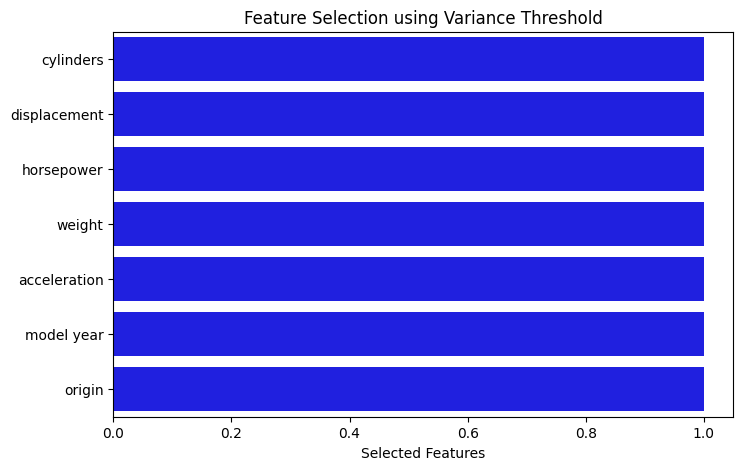

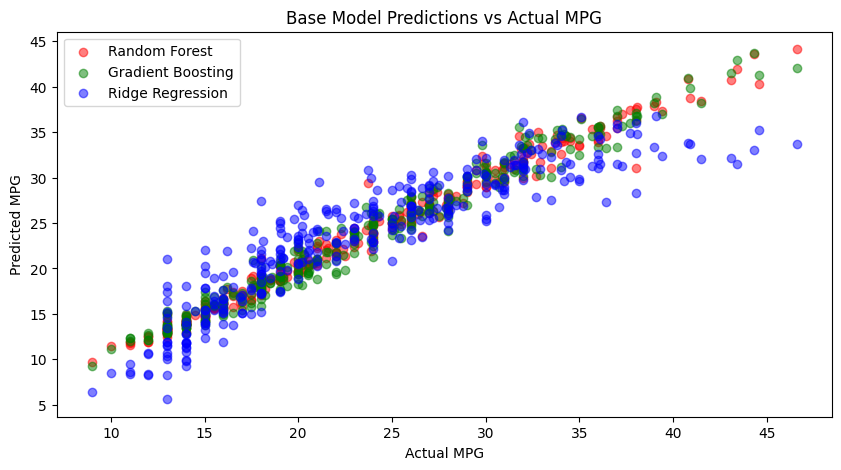

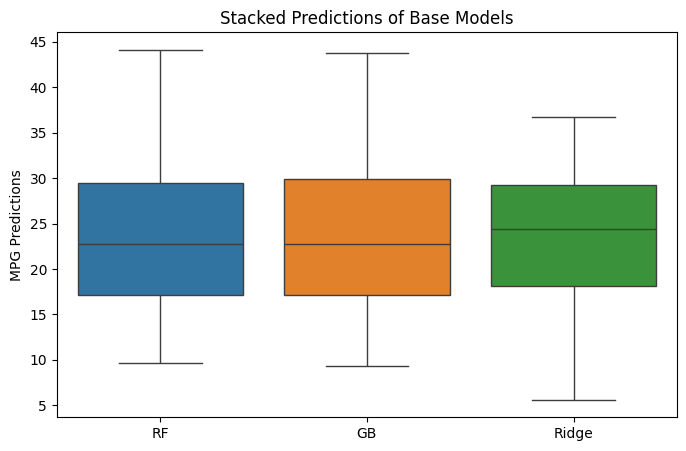

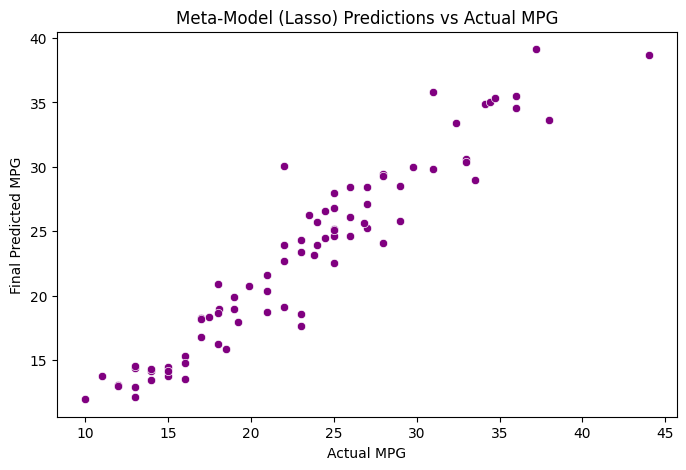

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define a function for plotting feature selection
def plot_feature_selection(feature_names):
    plt.figure(figsize=(8, 5))
    sns.barplot(y=feature_names, x=[1] * len(feature_names), orient='h', color='blue')
    plt.xlabel("Selected Features")
    plt.title("Feature Selection using Variance Threshold")
    plt.show()

# Define a function for plotting base model predictions
def plot_base_model_predictions(y_train, rf_pred, gb_pred, ridge_pred):
    plt.figure(figsize=(10, 5))
    plt.scatter(y_train, rf_pred, label="Random Forest", alpha=0.5, color='r')
    plt.scatter(y_train, gb_pred, label="Gradient Boosting", alpha=0.5, color='g')
    plt.scatter(y_train, ridge_pred, label="Ridge Regression", alpha=0.5, color='b')
    plt.xlabel("Actual MPG")
    plt.ylabel("Predicted MPG")
    plt.legend()
    plt.title("Base Model Predictions vs Actual MPG")
    plt.show()

# Define a function for plotting stacked predictions
def plot_stacked_predictions(y_train, stacked_train):
    plt.figure(figsize=(8, 5))
    sns.boxplot(data=stacked_train)
    plt.title("Stacked Predictions of Base Models")
    plt.ylabel("MPG Predictions")
    plt.show()

# Define a function for final model performance
def plot_final_performance(y_test, final_predictions):
    plt.figure(figsize=(8, 5))
    sns.scatterplot(x=y_test, y=final_predictions, color='purple')
    plt.xlabel("Actual MPG")
    plt.ylabel("Final Predicted MPG")
    plt.title("Meta-Model (Lasso) Predictions vs Actual MPG")
    plt.show()

# Plot feature selection
plot_feature_selection(selected_feature_names)

# Plot base model predictions
plot_base_model_predictions(y_train, rf_pred, gb_pred, ridge_pred)

# Plot stacked predictions
plot_stacked_predictions(y_train, stacked_train)

# Plot final performance
plot_final_performance(y_test, final_predictions)



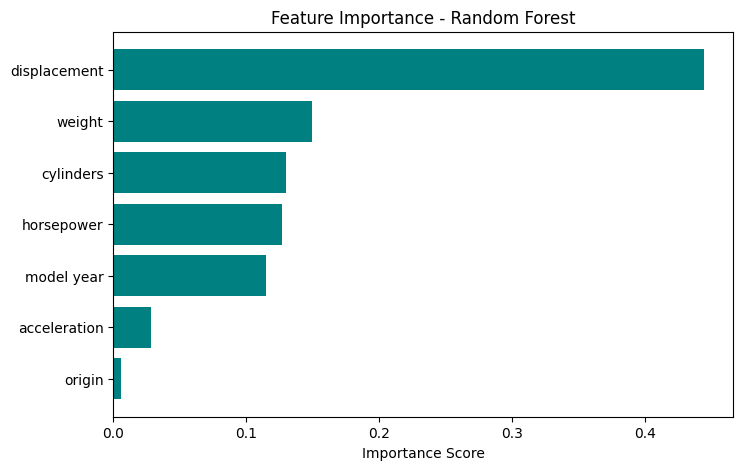

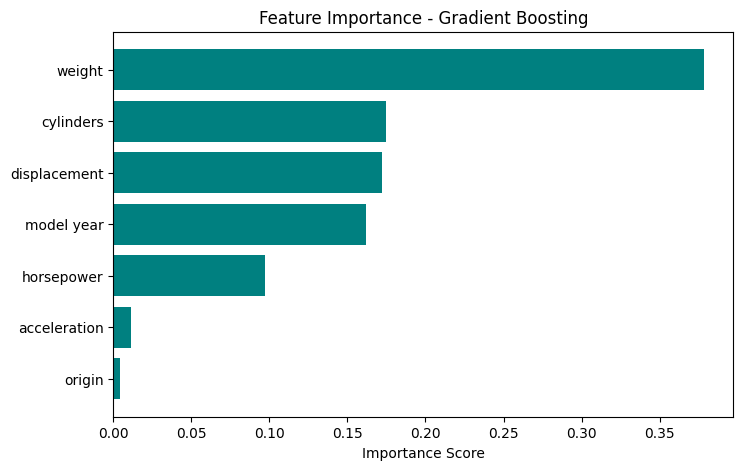

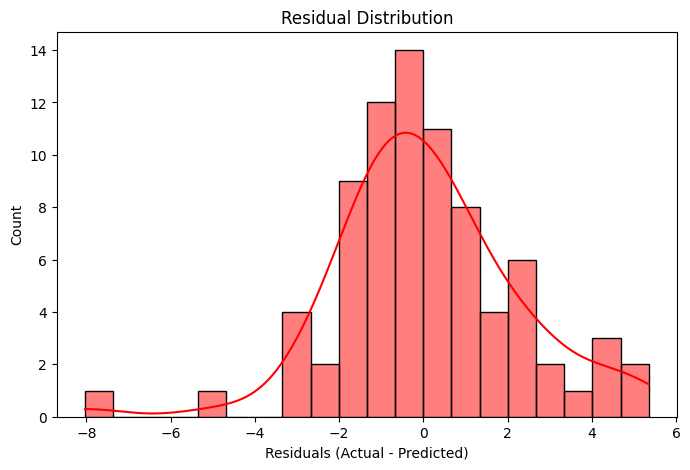

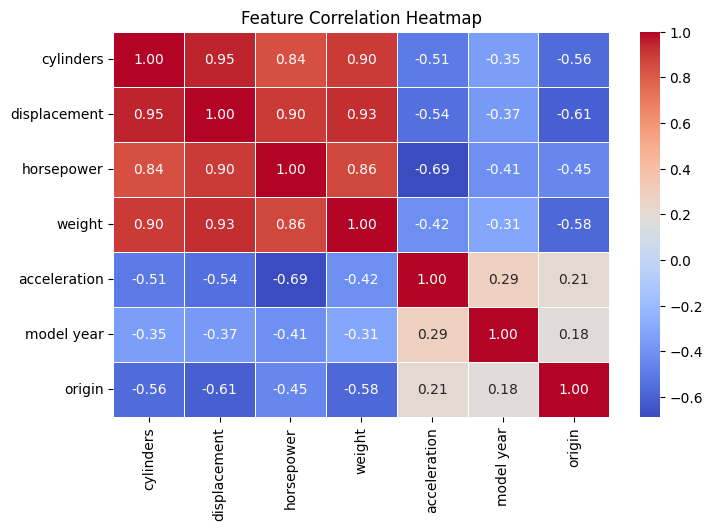

In [ ]:
import numpy as np

# Define function for feature importance visualization
def plot_feature_importance(model, feature_names, title):
    importance = model.feature_importances_
    sorted_idx = np.argsort(importance)
    plt.figure(figsize=(8, 5))
    plt.barh(np.array(feature_names)[sorted_idx], importance[sorted_idx], color='teal')
    plt.xlabel("Importance Score")
    plt.title(title)
    plt.show()

# Define function for residual plot (error distribution)
def plot_residuals(y_test, final_predictions):
    residuals = y_test - final_predictions
    plt.figure(figsize=(8, 5))
    sns.histplot(residuals, kde=True, bins=20, color="red")
    plt.xlabel("Residuals (Actual - Predicted)")
    plt.title("Residual Distribution")
    plt.show()

# Define function for correlation heatmap
def plot_correlation_heatmap(df):
    plt.figure(figsize=(8, 5))
    sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
    plt.title("Feature Correlation Heatmap")
    plt.show()

# Plot feature importance for Random Forest and Gradient Boosting
plot_feature_importance(rf, selected_feature_names, "Feature Importance - Random Forest")
plot_feature_importance(gb, selected_feature_names, "Feature Importance - Gradient Boosting")

# Plot residual distribution for final predictions
plot_residuals(y_test, final_predictions)

# Plot correlation heatmap of selected features
plot_correlation_heatmap(X)
